Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [ ]:
import gdown                                      # Подключим функцию gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

'20writers.zip'

In [ ]:
!unzip -qo 20writers.zip -d 20writers/

# выведем содержимое распакованного архива
!ls 20writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [ ]:
# Подключение всех необходимых библиотек

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Input, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.optimizers import Adam

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

# Библиотеки для балансировки базы
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Сохраним путь к папке с выборкой
path = Path("20writers")

# Список для текста базы и распознаваемых классов (имен писателей)
text = []
class_names = []

# Объединим тексты писателей в один список
for f in path.iterdir():
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))

In [ ]:
# Определим длины текстов 20 писателей
text_lens = [len(t) for t in text]
split_indices = [int(lenth * 0.8) for lenth in text_lens]
print(text_lens)

[1965119, 2255254, 2952792, 1972541, 6611627, 2579246, 3408339, 2399413, 3089426, 1980206, 1992830, 3104712, 3357061, 2001064, 5178950, 3386268, 2152214, 969109, 2523380, 2328900]


In [ ]:
# Разделим выборку на обучающую 80% и тестовую 20%
train_text = []
test_text = []
for i, t in enumerate(text):
    train_text.append(t[:split_indices[i]])
    test_text.append(t[split_indices[i]:])

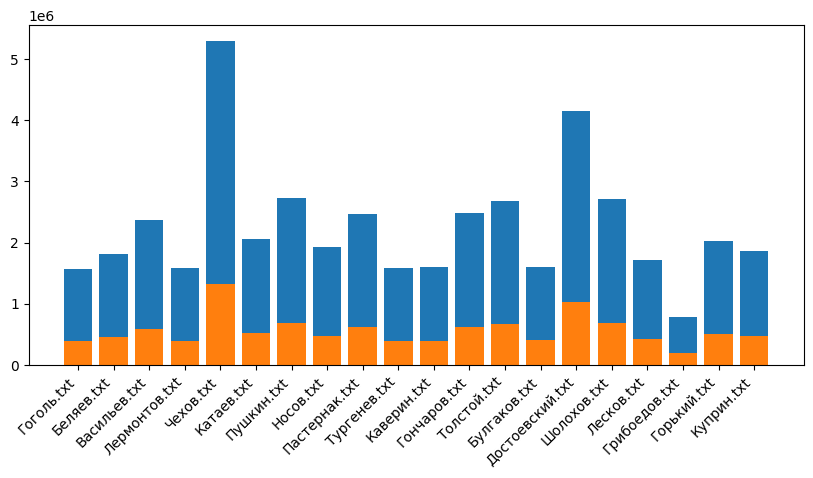

In [ ]:
# Проверим сбалансированность выборок по классам, выведем гистограмму
fig = plt.figure(figsize=(10, 5))
c_train = split_indices
c_test = [i-j for i, j in zip(text_lens, split_indices)]
plt.bar(class_names, c_train)
plt.bar(class_names, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
VOCAB_SIZE = 25_000
WIN_SIZE = 4000
WIN_HOPE = 500

In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]

In [ ]:
# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))

In [ ]:
# Преобразование в формат Bag of Words
with timex():
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, oov_token="неизвестное_слово")
    tokenizer.fit_on_texts(text)
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)

Время обработки: 26.37 с


In [ ]:
# Вычисление весов классов
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
class_weight_dict = dict(enumerate(class_weights))
print("Веса классов:", class_weight_dict)

Веса классов: {0: np.float64(1.4335685483870968), 1: np.float64(1.2881340579710145), 2: np.float64(0.9518741633199465), 3: np.float64(1.3997047244094487), 4: np.float64(0.4131609529343405), 5: np.float64(1.1505663430420712), 6: np.float64(0.8577201447527141), 7: np.float64(1.1733498349834983), 8: np.float64(0.9468042609853529), 9: np.float64(1.3969548133595284), 10: np.float64(1.4306841046277665), 11: np.float64(0.8724539877300613), 12: np.float64(0.8335873388042204), 13: np.float64(1.4660824742268042), 14: np.float64(0.530634328358209), 15: np.float64(0.858756038647343), 16: np.float64(1.2562720848056537), 17: np.float64(2.9382231404958676), 18: np.float64(1.0425953079178885), 19: np.float64(1.2344618055555556)}


In [ ]:
with timex():
    x_train_matrix = tokenizer.sequences_to_matrix(x_train.tolist(), mode="binary").astype("float16")
    x_test_matrix = tokenizer.sequences_to_matrix(x_test.tolist(), mode="binary").astype("float16")

# Вывод формы обучающей выборки
print("Форма обучающей выборки:", x_train_matrix.shape)
print("Форма тестовой выборки:", x_test_matrix.shape)

Время обработки: 25.17 с
Форма обучающей выборки: (14221, 25000)
Форма тестовой выборки: (3466, 25000)


In [ ]:
# Преобразуем one-hot метки в числовые классы
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

In [ ]:
# Подсчёт количества окон по классам
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")

Обучающая выборка:
Класс 0: 496 окон
Класс 1: 552 окон
Класс 2: 747 окон
Класс 3: 508 окон
Класс 4: 1721 окон
Класс 5: 618 окон
Класс 6: 829 окон
Класс 7: 606 окон
Класс 8: 751 окон
Класс 9: 509 окон
Класс 10: 497 окон
Класс 11: 815 окон
Класс 12: 853 окон
Класс 13: 485 окон
Класс 14: 1340 окон
Класс 15: 828 окон
Класс 16: 566 окон
Класс 17: 242 окон
Класс 18: 682 окон
Класс 19: 576 окон

Тестовая выборка:
Класс 0: 119 окон
Класс 1: 133 окон
Класс 2: 179 окон
Класс 3: 121 окон
Класс 4: 435 окон
Класс 5: 149 окон
Класс 6: 197 окон
Класс 7: 160 окон
Класс 8: 182 окон
Класс 9: 121 окон
Класс 10: 121 окон
Класс 11: 192 окон
Класс 12: 215 окон
Класс 13: 111 окон
Класс 14: 337 окон
Класс 15: 211 окон
Класс 16: 129 окон
Класс 17: 52 окон
Класс 18: 163 окон
Класс 19: 139 окон


In [ ]:
model = Sequential(
    [
        Input((VOCAB_SIZE,)),
        Dropout(0.6),
        Dense(128, activation="relu"),
        Dropout(0.6),
        Dense(64, activation="relu"),
        Dropout(0.6),
        Dense(20, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,200,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,209,684 (12.24 MB)

 Trainable params: 3,209,684 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучим модель с форматом данных в Bag of Words
history = model.fit(
    x_train_matrix,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test_matrix, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.0917 - loss: 2.9998 - val_accuracy: 0.5629 - val_loss: 2.3027
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3052 - loss: 2.1731 - val_accuracy: 0.8286 - val_loss: 1.3260
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5124 - loss: 1.4538 - val_accuracy: 0.9559 - val_loss: 0.7528
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6556 - loss: 1.0161 - val_accuracy: 0.9657 - val_loss: 0.4457
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7463 - loss: 0.7467 - val_accuracy: 0.9720 - val_loss: 0.3023
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8049 - loss: 0.5734 - val_accuracy: 0.9714 - val_loss: 0.2422
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8424 - loss: 0.4716 - val_accuracy: 0.9737 - val_loss: 0.1982
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8585 - loss: 0.4204 - val_accuracy: 0.9700 - 

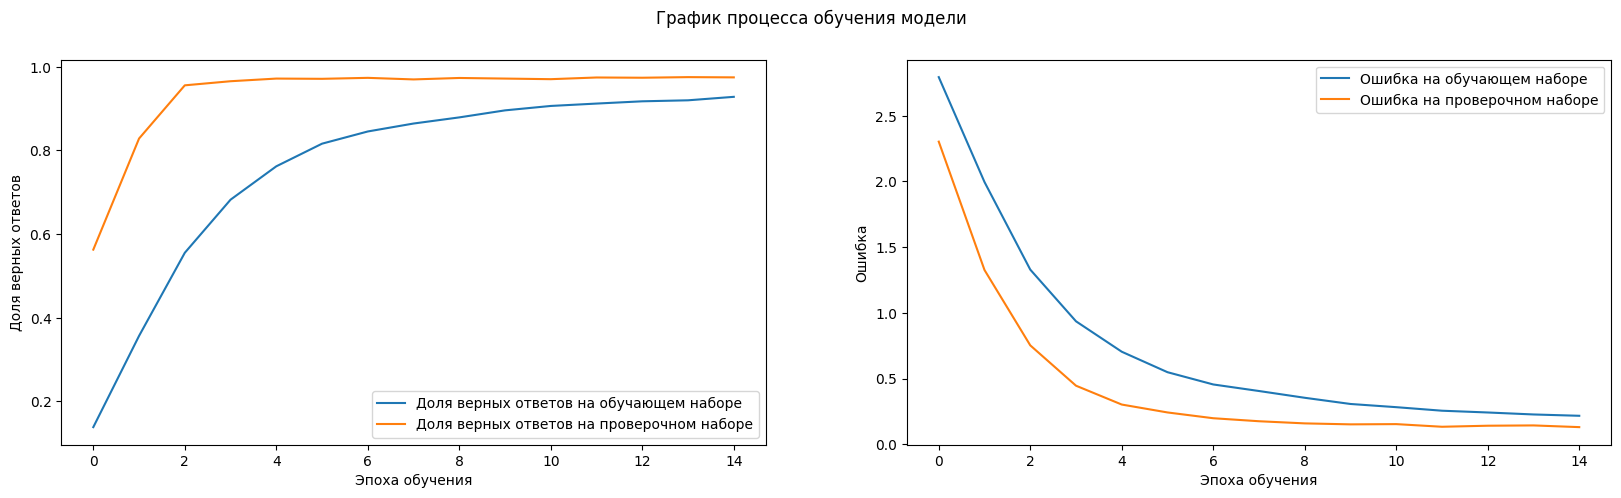

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()

In [ ]:
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "Правильно" if cls_pred == cls else "Неправильно"
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


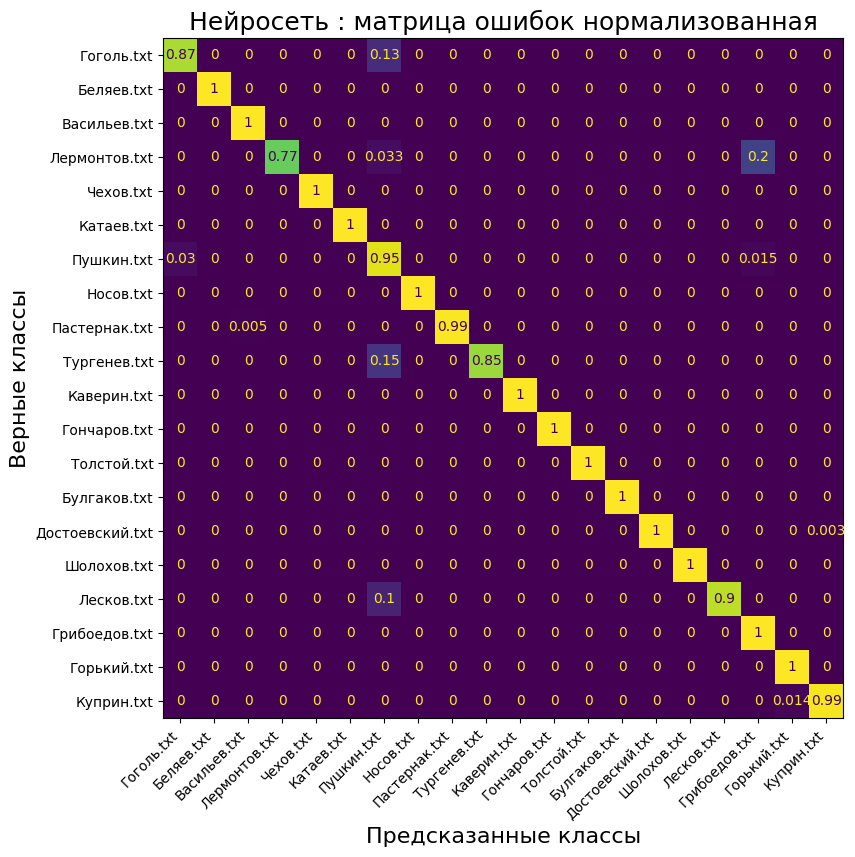

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Гоголь.txt            87% сеть отнесла к классу Гоголь.txt           - Правильно
Класс: Беляев.txt           100% сеть отнесла к классу Беляев.txt           - Правильно
Класс: Васильев.txt         100% сеть отнесла к классу Васильев.txt         - Правильно
Класс: Лермонтов.txt         77% сеть отнесла к классу Лермонтов.txt        - Правильно
Класс: Чехов.txt            100% сеть отнесла к классу Чехов.txt            - Правильно
Класс: Катаев.txt           100% сеть отнесла к классу Катаев.txt           - Правильно
Класс: Пушкин.txt            95% сеть отнесла к классу Пушкин.txt           - Правильно
Класс: Носов.txt            100% сеть отнесла к классу Носов.txt            - Правильно
Класс: Пастернак.txt        100% сеть отнесла к классу Пастернак.txt        - Правильно
Класс: Тургенев.txt          85% сеть отнесла к классу Тургенев.txt         - Правильно
Класс: 

In [ ]:
eval_model(model, x_test_matrix, y_test, class_names)

In [ ]:
# Создадим модель с использованием слоя Embedding
model_emb = Sequential(
    [
        Embedding(VOCAB_SIZE, 400, input_length=WIN_SIZE),
        SpatialDropout1D(0.4),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(20, activation="softmax"),
    ]
)
model_emb.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_emb = model_emb.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=256,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - accuracy: 0.1618 - loss: 2.7040 - val_accuracy: 0.6304 - val_loss: 1.5147
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.9269 - loss: 0.3093 - val_accuracy: 0.7418 - val_loss: 0.9662
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9858 - loss: 0.0743 - val_accuracy: 0.7848 - val_loss: 0.8010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9940 - loss: 0.0375 - val_accuracy: 0.7983 - val_loss: 0.7538
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9978 - loss: 0.0234 - val_accuracy: 0.8188 - val_loss: 0.6870
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9986 - loss: 0.0178 - val_accuracy: 0.8027 - val_loss: 0.7135
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9980 - loss: 0.0164 - val_accuracy: 0.8029 - val_loss: 0.6882
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9982 - loss: 0.0140 - val_accuracy

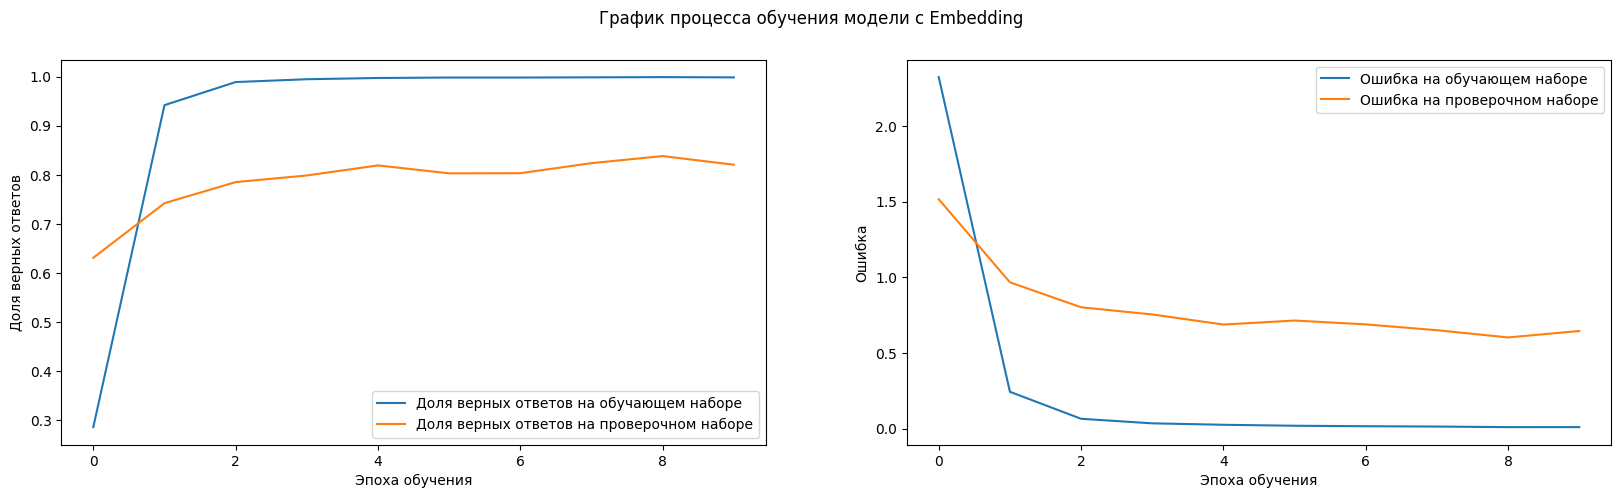

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


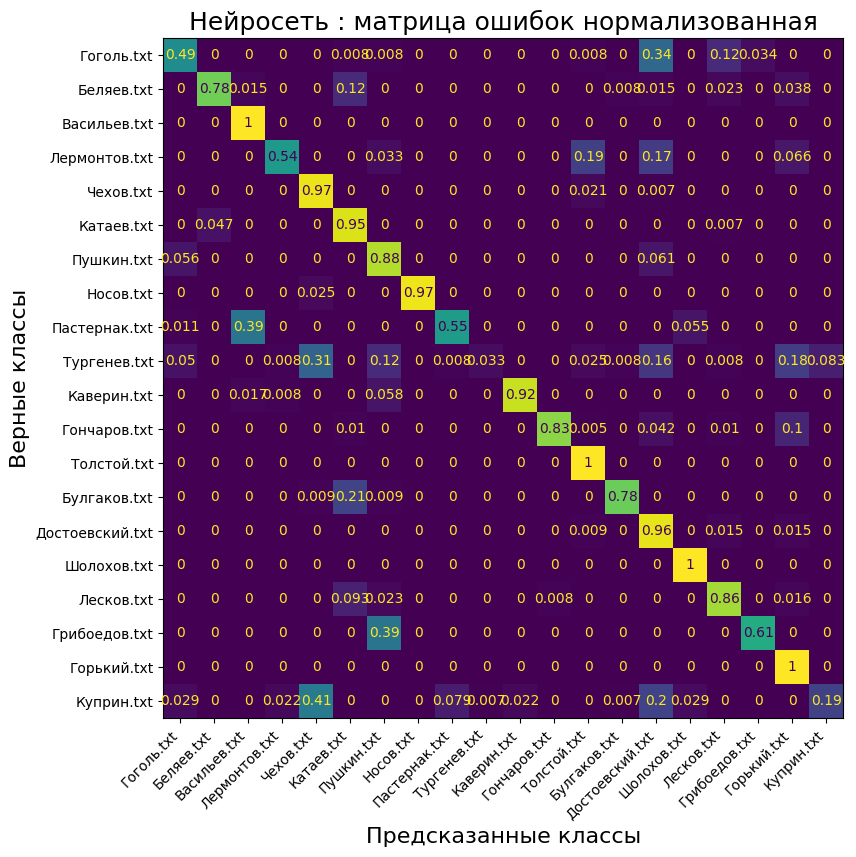

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Гоголь.txt            49% сеть отнесла к классу Гоголь.txt           - Правильно
Класс: Беляев.txt            78% сеть отнесла к классу Беляев.txt           - Правильно
Класс: Васильев.txt         100% сеть отнесла к классу Васильев.txt         - Правильно
Класс: Лермонтов.txt         54% сеть отнесла к классу Лермонтов.txt        - Правильно
Класс: Чехов.txt             97% сеть отнесла к классу Чехов.txt            - Правильно
Класс: Катаев.txt            95% сеть отнесла к классу Катаев.txt           - Правильно
Класс: Пушкин.txt            88% сеть отнесла к классу Пушкин.txt           - Правильно
Класс: Носов.txt             98% сеть отнесла к классу Носов.txt            - Правильно
Класс: Пастернак.txt         55% сеть отнесла к классу Пастернак.txt        - Правильно
Класс: Тургенев.txt          31% сеть отнесла к классу Чехов.txt            - Неправильно
Класс

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели с Embedding")
ax1.plot(history_emb.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history_emb.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_emb.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_emb.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()
eval_model(model_emb, x_test, y_test, class_names)